# Statistics computation

## Notebook setup

In [1]:
# %matplotlib notebook  # does not work in JupyterLab
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../..')

In [3]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
import s1etad

## Product introspection and navigation

In [5]:
filename = '../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE'

In [6]:
product = s1etad.Sentinel1Etad(filename)

In [7]:
product

Sentinel1Etad("../../sample-products/S1B_IW_ETA__AXDH_20200127T113414_20200127T113858_020002_025D72_0096.SAFE")  # 0x7fce4fd88390
Number of Sentinel-1 slices: 11
Sentinel-1 products list:
  S1B_IW_SLC__1ADH_20200127T113414_20200127T113444_020002_025D72_FD42.SAFE
  S1B_IW_SLC__1ADH_20200127T113442_20200127T113510_020002_025D72_FC8F.SAFE
  S1B_IW_SLC__1ADH_20200127T113507_20200127T113534_020002_025D72_78DF.SAFE
  S1B_IW_SLC__1ADH_20200127T113532_20200127T113559_020002_025D72_1ABB.SAFE
  S1B_IW_SLC__1ADH_20200127T113557_20200127T113624_020002_025D72_6706.SAFE
  S1B_IW_SLC__1ADH_20200127T113622_20200127T113649_020002_025D72_78F0.SAFE
  S1B_IW_SLC__1ADH_20200127T113647_20200127T113715_020002_025D72_11FB.SAFE
  S1B_IW_SLC__1ADH_20200127T113712_20200127T113739_020002_025D72_FCC6.SAFE
  S1B_IW_SLC__1ADH_20200127T113737_20200127T113804_020002_025D72_1FED.SAFE
  S1B_IW_SLC__1ADH_20200127T113802_20200127T113829_020002_025D72_C434.SAFE
  S1B_IW_SLC__1ADH_20200127T113827_20200127T113858_020002_025D

In [8]:
swath = product['IW1']

In [9]:
burst = swath[1]

In [10]:
t, tau = burst.get_burst_grid()
print('t.shape', t.shape)
print('tau.shape', tau.shape)

t.shape (111,)
tau.shape (403,)


In [11]:
correction = burst.get_correction(s1etad.ECorrectionType.SUM, meter=True)

In [12]:
rg_correction = correction['x']
az_correction = correction['y']
print('rg_correction.shape', rg_correction.shape)
print('az_correction.shape', az_correction.shape)

rg_correction.shape (111, 403)
az_correction.shape (111, 403)


Text(0.5, 1.0, 'sum correction in range direction')

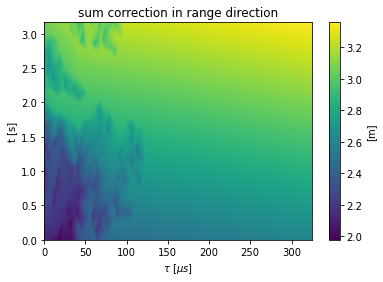

In [13]:
plt.figure()
plt.imshow(correction['x'], extent=[tau[0]*1e6, tau[-1]*1e6, t[0], t[-1]], aspect='auto')
plt.xlabel(r'$\tau\ [\mu s]$')
plt.ylabel('t [s]')
plt.colorbar().set_label('[{}]'.format(correction['unit']))
plt.title('{} correction in range direction'.format(correction['name']))

## Collect data statistics

**NOTE**: statistics are also available in the XML annotation file included in the S1-ETAD product

In [14]:
import pandas as pd

### Initialize dataframes

In [15]:
x_corrections_names = ['tropospheric', 'ionospheric', 'geodetic', 'doppler', 'sum']
xcols = [('', 'bIndex'), ('', 't')] + [
    (cname, name)
    for cname in x_corrections_names
    for name in ('min', 'mean', 'std', 'max')
]
xcols = pd.MultiIndex.from_tuples(xcols)
xstats_df = pd.DataFrame(columns=xcols, dtype=np.float64)

y_corrections_names = ['geodetic', 'bistatic', 'fmrate', 'sum']
ycols = [('', 'bIndex'), ('', 't')] + [
    (cname, name)
    for cname in y_corrections_names
    for name in ('min', 'mean', 'std', 'max')
]
ycols = pd.MultiIndex.from_tuples(ycols)
ystats_df = pd.DataFrame(columns=ycols, dtype=np.float64)

### Collect statistics

In [16]:
for swath in product:
    for burst in swath:
        az, _ = burst.get_burst_grid()
        t = np.mean(az[[0, -1]])
        
        # range
        row = {
            ('', 'bIndex'): burst.burst_index,
            ('', 't'): t
        }
        for name in x_corrections_names:
            data = burst.get_correction(name, meter=True)
            row[(name, 'min')] = data['x'].min()
            row[(name, 'mean')] = data['x'].mean()
            row[(name, 'std')] = data['x'].std()
            row[(name, 'max')] = data['x'].max()
        xstats_df = xstats_df.append(row, ignore_index=True)
        
        # azimuth
        row = {
            ('', 'bIndex'): int(burst.burst_index),
            ('', 't'): t
        }
        for name in y_corrections_names:
            # NOTE: meter is False in this case due to a limitation of the
            # current implementation
            data = burst.get_correction(name, meter=True)
            row[(name, 'min')] = data['y'].min()
            row[(name, 'mean')] = data['y'].mean()
            row[(name, 'std')] = data['y'].std()
            row[(name, 'max')] = data['y'].max()

        ystats_df = ystats_df.append(row, ignore_index=True)

### Inspect results

#### Correction statistics in range direction

In [17]:
xstats_df.head()

tropospheric                               ionospheric  \
  bIndex          t          min      mean       std       max         min   
0    1.0   1.582778     2.155326  2.714470  0.145982  2.858699    0.009107   
1    4.0   4.331057     2.163874  2.707724  0.147308  2.858642    0.008750   
2    7.0   7.093725     2.298610  2.738260  0.095753  2.858575    0.008407   
3   10.0   9.856392     2.329711  2.735871  0.099814  2.860330    0.008076   
4   13.0  12.604671     2.220333  2.681844  0.142236  2.860439    0.007739   

                                 ...  geodetic             doppler            \
       mean       std       max  ...       std       max       min      mean   
0  0.009528  0.000177  0.009969  ...  0.001659  0.119038 -0.388467 -0.001669   
1  0.009168  0.000172  0.009595  ...  0.001654  0.118861 -0.390278  0.000689   
2  0.008809  0.000167  0.009222  ...  0.001668  0.118819 -0.391369  0.000025   
3  0.008454  0.000161  0.008853  ...  0.001664  0.118681 -0.392313 -0.001560   
4  0.008107  0.000154  0.008488  ...  0.001647  0.118491 -0.386082  0.000791   

                            sum                                
        std       max       min      mean       std       max  
0  0.220652  0.387346  1.977618  2.848050  0.281908  3.358570  
1  0.222749  0.393396  2.117201  2.843175  0.259000  3.363231  
2  0.223233  0.393376  2.247333  2.872574  0.241518  3.364020  
3  0.222806  0.390904  2.073561  2.868118  0.254228  3.360668  
4  0.220615  0.389624  2.029879  2.815948  0.275655  3.360558  

[5 rows x 22 columns]

#### Maximum value of corrections in range direction

In [18]:
xstats_df.abs().max()

              bIndex    306.000000
              t         282.079880
tropospheric  min         3.076796
              mean        3.189554
              std         0.227448
              max         3.305507
ionospheric   min         0.014389
              mean        0.014750
              std         0.000205
              max         0.015121
geodetic      min         0.113129
              mean        0.116042
              std         0.001812
              max         0.119038
doppler       min         0.475521
              mean        0.006117
              std         0.268563
              max         0.471421
sum           min         2.730788
              mean        3.306536
              std         0.378128
              max         3.867100
dtype: float64

#### Correction statistics in azimuth direction

In [19]:
ystats_df.head()

geodetic                                bistatic  \
  bIndex          t       min      mean       std       max       min   
0    1.0   1.582778  0.008805  0.009118  0.000159  0.009418 -3.657967   
1    4.0   4.331057  0.008865  0.009175  0.000158  0.009475 -3.657982   
2    7.0   7.093725  0.008918  0.009232  0.000159  0.009533 -3.657997   
3   10.0   9.856392  0.008980  0.009290  0.000159  0.009590 -3.658013   
4   13.0  12.604671  0.009036  0.009348  0.000158  0.009646 -3.658029   

                                   fmrate                                \
       mean       std       max       min      mean       std       max   
0 -3.109659  0.317352 -2.561351 -0.569971  0.040845  0.152048  1.046240   
1 -3.109672  0.317354 -2.561361 -1.120739 -0.003720  0.152041  0.735728   
2 -3.109685  0.317355 -2.561372 -0.823152  0.000050  0.091578  0.471964   
3 -3.109698  0.317356 -2.561383 -0.598072  0.000486  0.096002  0.764596   
4 -3.109712  0.317358 -2.561394 -0.627781  0.010036  0.143159  0.808039   

        sum                                
        min      mean       std       max  
0 -4.288769 -3.395230  0.388531 -1.899021  
1 -4.235378 -3.439752  0.328276 -2.288562  
2 -4.237398 -3.435940  0.326020 -2.424142  
3 -4.335532 -3.435461  0.346501 -2.123276  
4 -4.390991 -3.425868  0.363987 -2.126139

#### Maximum value of corrections in azimuth direction

In [20]:
ystats_df.abs().max()

          bIndex    306.000000
          t         282.079880
geodetic  min         0.013753
          mean        0.013995
          std         0.000167
          max         0.014231
bistatic  min         3.661955
          mean        3.113049
          std         0.376610
          max         2.564143
fmrate    min         1.957247
          mean        0.127447
          std         0.906995
          max         1.909569
sum       min         5.042909
          mean        3.481153
          std         0.979676
          max         2.857225
dtype: float64

### Plot

<Figure size 432x288 with 0 Axes>

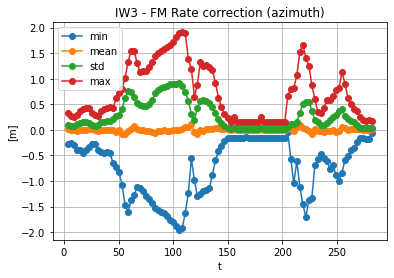

In [21]:
iw3 = product['IW3']
iw3_df = ystats_df[ystats_df[('', 'bIndex')].isin(iw3.burst_list)]

t = iw3_df[('','t')]
fmrate_df = iw3_df.loc[:,'fmrate']
fmrate_df.insert(0, 't', t)
fmrate_df = fmrate_df.sort_values(by='t')

plt.figure()
fmrate_df.plot(x='t', style='o-')
plt.ylabel('t [s]')
plt.ylabel('[m]')
plt.title('IW3 - FM Rate correction (azimuth)')
plt.grid()

In [22]:
xstats_df.iloc[xstats_df['sum', 'max'].abs().argmax()]

              bIndex    306.000000
              t         282.079880
tropospheric  min         3.076796
              mean        3.189554
              std         0.065287
              max         3.303904
ionospheric   min         0.014389
              mean        0.014750
              std         0.000194
              max         0.015121
geodetic      min         0.088957
              mean        0.091113
              std         0.001214
              max         0.093352
doppler       min        -0.471009
              mean        0.000176
              std         0.266898
              max         0.468082
sum           min         2.723540
              mean        3.305272
              std         0.274704
              max         3.867100
Name: 305, dtype: float64

In [23]:
ystats_df.iloc[ystats_df['sum', 'max'].abs().argmax()]

          bIndex    241.000000
          t         222.236469
geodetic  min         0.012263
          mean        0.012542
          std         0.000145
          max         0.012807
bistatic  min        -3.660727
          mean       -3.112005
          std         0.317592
          max        -2.563283
fmrate    min        -0.203718
          mean       -0.006160
          std         0.029448
          max         0.167373
sum       min        -4.187425
          mean       -3.441411
          std         0.318898
          max        -2.857225
Name: 80, dtype: float64

In [24]:
xstats_df.loc[xstats_df['']['bIndex'] == 306]['sum']

,min,mean,std,max
305,2.72354,3.305272,0.274704,3.8671


In [25]:
ystats_df.loc[ystats_df['']['bIndex'] == 241]['sum']

,min,mean,std,max
80,-4.187425,-3.441411,0.318898,-2.857225
